In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../data/dev/logreg'
plot_folder = '../plots/dev'

make_dir(plot_folder)

In [9]:
metrics_df = pd.read_parquet(os.path.join(folder, 'metrics.parquet'))
confusion_matrix_df = pd.read_parquet(os.path.join(folder, 'confusion_matrix.parquet'))

<AxesSubplot:xlabel='set', ylabel='value'>

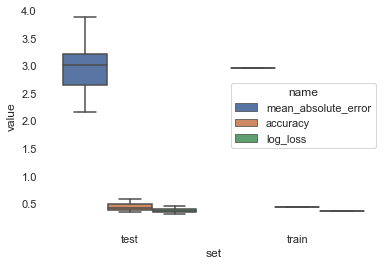

In [12]:
sns.boxplot(data=metrics_df, x='set', hue='name', y='value')

In [13]:
confusion_matrix_df.columns

Index(['set', 'cv_split', 'y_true', 'y_pred', 'value'], dtype='object')

In [33]:
# Todo: double check the normalisation
cm_g_df = confusion_matrix_df.groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

<AxesSubplot:xlabel='y_pred', ylabel='y_true'>

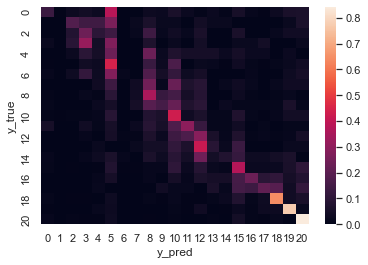

In [35]:
sns.heatmap(cm.loc['test'])

<AxesSubplot:xlabel='y_pred', ylabel='value'>

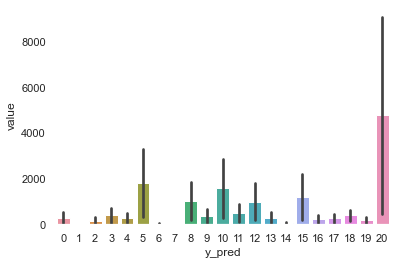

In [36]:
pred_df = confusion_matrix_df.groupby(['set', 'y_pred'])['value'].sum().reset_index()
sns.barplot(data=pred_df, x='y_pred', y='value')

<AxesSubplot:xlabel='y_true', ylabel='value'>

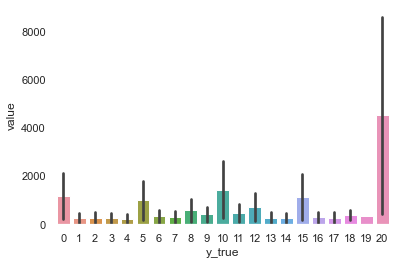

In [37]:
true_df = confusion_matrix_df.groupby(['set', 'y_true'])['value'].sum().reset_index()
sns.barplot(data=true_df, x='y_true', y='value')